In [1]:
#### import package and library

import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import time
import datetime
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('E:/CSU LA/TERMS/FALL 2017/CS4660 Artificial Intelligence/PROJECT GITHUB/PredictNYTimesArticlePopularity/Hiroko/data/NYTimesBlogTrain.csv')

y = df['Popular'] 

# convert date to timestamp (milliseconds, divide by a million to get a more readable decimal)
df['PubDate'] = df['PubDate'].apply(lambda x: time.mktime(time.strptime(x, '%Y-%m-%d %H:%M:%S'))/1000000)

#replace empty values with the middle most common word

def nan_to_meaningful(x, col):
    if pd.isnull(x):
        mc = Counter(col).most_common(8)
        mc = [str(i[0]) for i in mc]
        if 'nan' in mc:
            mc.remove('nan')
        rep = mc.pop((len(mc))//2)
        return rep
        
    return x
        
my_list = ["NewsDesk","SectionName","SubsectionName","Headline","Snippet","Abstract"]

for f in my_list: 
    df[f] = df[f].apply(nan_to_meaningful, args=(df[f],))

# split sentences into series of words so each word can be a column
def string_to_series_of_words(x):    
    return pd.Series(x.split(" "))


for f in my_list[3:]:
    df[f] = df[f].apply(string_to_series_of_words)
    
    
df=pd.get_dummies(df,columns=["NewsDesk","SectionName","SubsectionName", "Headline","Snippet","Abstract"],
                  drop_first=False)

new_features = list(df.dtypes.index)
new_features.remove('Popular')

X = df[new_features]

# print(new_features)



#### Split training data into train and test set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

#### Logistic Regression

In [5]:
logreg = LogisticRegression()

# training
logreg.fit(X_train, y_train)

# predict label
y_predict_lr = logreg.predict(X_test)

# calculate accuracy
log_accuracy = accuracy_score(y_test, y_predict_lr)

print('Logistic Regression: ', log_accuracy)

Logistic Regression:  0.899082568807


#### calculate the probability of Logistic classification accuracy

In [6]:
y_predict_prob_lr = logreg.predict_proba(X_test)

print(y_predict_prob_lr[:  ,1])


# calculate AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)
AUC = metrics.auc(fpr, tpr)
print('AUC: ',AUC)

[ 0.04964967  0.07444344  0.00721147  0.76788051  0.0926948   0.06117942
  0.12726437  0.01043104  0.13490822  0.01765873  0.01994512  0.82733597
  0.03365332  0.7016426   0.06962171  0.89198561  0.19236053  0.07192218
  0.14656281  0.09527458  0.05097151  0.05156174  0.81737894  0.01437104
  0.01786335  0.06956971  0.02385712  0.04054989  0.02204983  0.10316033
  0.08093164  0.06571542  0.00667677  0.01635109  0.08309992  0.03611003
  0.06858993  0.04751314  0.67406315  0.04644706  0.04122243  0.01605612
  0.06439374  0.00749739  0.04152465  0.04106292  0.01275394  0.05311057
  0.00496637  0.11572073  0.21634845  0.10950306  0.08547704  0.69677013
  0.57987673  0.05955307  0.03723823  0.75263951  0.03201164  0.01533336
  0.24817446  0.21498897  0.03822608  0.68311801  0.23527835  0.0712058
  0.04688737  0.01395912  0.05533585  0.02440405  0.22778234  0.01314142
  0.07302594  0.10155531  0.04480162  0.03896722  0.05020096  0.08142647
  0.03991522  0.05943701  0.01152314  0.01384881  0.

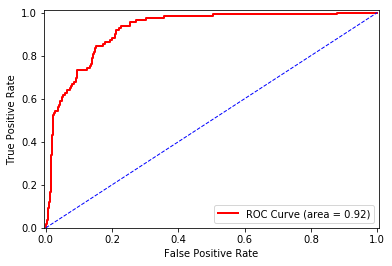

In [7]:
%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Define X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")

plt.show()

#### Randomforest Classifier

In [8]:
rf =  RandomForestClassifier(n_estimators = 50, bootstrap = True, random_state=0, criterion='entropy')
rf.fit(X_train, y_train)

y_predict_randF = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_predict_randF)

print("\nAccuracy: ", accuracy) 


Accuracy:  0.909785932722


#### DecisionTree Classifier

In [9]:
decTree =  DecisionTreeClassifier(criterion='entropy', min_samples_split=4, random_state=0)
decTree.fit(X_train, y_train)
y_predict_decTree = decTree.predict(X_test)

accuracy_decTree = accuracy_score(y_test, y_predict_decTree)

print("\nAccuracy Decision Tree: ", accuracy_decTree) 



Accuracy Decision Tree:  0.906727828746


#### ExtraTreesClassifier

In [10]:
etc = ExtraTreesClassifier(n_estimators=52, max_depth=None, min_samples_split=5, random_state=0, criterion='entropy')
etc.fit(X_train,y_train)

predictions_etc = etc.predict(X_test)
accuracy_etc = accuracy_score(y_test, predictions_etc)

print("\nAccuracy ExtraTreesClassifier: ", accuracy_etc) 


Accuracy ExtraTreesClassifier:  0.911314984709


#### Combine Prediction

In [11]:
combined_predictions=pd.DataFrame([y_predict_randF, y_predict_decTree, predictions_etc])

consolidated_predictions = list(combined_predictions.mode().values[0])

acc= accuracy_score(y_test, consolidated_predictions)

print("\n Combined Accuracy: ", acc) 


 Combined Accuracy:  0.915902140673


In [15]:
#Ada boost
from sklearn.ensemble import AdaBoostClassifier
dt = DecisionTreeClassifier()
clf = AdaBoostClassifier(n_estimators=100, base_estimator=dt,learning_rate=1)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
acc_score = accuracy_score(y_test, prediction)
print("Accuracy by Ada Boost Classifier: ", acc_score)

Accuracy by Ada Boost Classifier:  0.891437308869


In [16]:
#Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
acc_score = accuracy_score(y_test, prediction)
print("Accuracy by Gradient Boosting Classifier: ", acc_score)

Accuracy by Gradient Boosting Classifier:  0.899082568807
